# Inference demo for DUC models

## Overview
This notebook can be used for inference on DUC ONNX models. The demo shows how to use the trained models to do inference in MXNet.

## Models supported
* ResNet101_DUC_HDC

## Prerequisites
The following packages need to be installed before proceeding:
* Protobuf compiler - `sudo apt-get install protobuf-compiler libprotoc-dev` (required for ONNX. This will work for any linux system. For detailed installation guidelines head over to [ONNX documentation](https://github.com/onnx/onnx#installation))
* ONNX - `pip install onnx`
* MXNet - `pip install mxnet --pre -U` (tested on this version GPU, can use other versions. `--pre` indicates a pre build of MXNet which is required here for ONNX version compatibility. `-U` uninstalls any existing MXNet version allowing for a clean install)
* numpy - `pip install numpy`
* OpenCV - `pip install opencv-python`
* PIL - `pip install pillow`

Also the following script (included in the repo) must be present in the same folder as this notebook:
* `cityscapes_labels.py` (contains segmentation category labels)

In order to do inference with a python script:
* Generate the script : In Jupyter Notebook browser, go to File -> Download as -> Python (.py)
* Run the script: `python duc_inference.py`

### Import dependencies
Verify that all dependencies are installed using the cell below. Continue if no errors encountered, warnings can be ignored.

In [1]:
import mxnet as mx
import cv2 as cv
import numpy as np
import os
from PIL import Image
import math
from collections import namedtuple
from mxnet.contrib.onnx import import_model
import cityscapes_labels

### Preprocess image
`preprocess()` : Prepares input image, subtracts RGB mean and converts it to ndarray to input to the model

In [2]:
def preprocess(im):
    # Convert to float32
    test_img = im.astype(np.float32)
    # Extrapolate image with a small border in order obtain an accurate reshaped image after DUC layer
    test_shape = [im.shape[0],im.shape[1]]
    cell_shapes = [math.ceil(l / 8)*8 for l in test_shape]
    test_img = cv.copyMakeBorder(test_img, 0, max(0, int(cell_shapes[0]) - im.shape[0]), 0, max(0, int(cell_shapes[1]) - im.shape[1]), cv.BORDER_CONSTANT, value=rgb_mean)
    test_img = np.transpose(test_img, (2, 0, 1))
    # subtract rbg mean
    for i in range(3):
        test_img[i] -= rgb_mean[i]
    test_img = np.expand_dims(test_img, axis=0)
    # convert to ndarray
    test_img = mx.ndarray.array(test_img)
    return test_img

### Generate predictions
`get_palette()` : Returns predefined color palette for generating output segmentation map

`colorize()` : Generate the segmentation map using output `labels` generated by the model and color palette from `get_palette()`

`predict()` : Performs forward pass on the model using the preprocessed input, reshapes the output to match input image dimensions, generates colorized segmentation map using `colorize()`

In [3]:
def get_palette():
    # get train id to color mappings from file
    trainId2colors = {label.trainId: label.color for label in cityscapes_labels.labels}
    # prepare and return palette
    palette = [0] * 256 * 3
    for trainId in trainId2colors:
        colors = trainId2colors[trainId]
        if trainId == 255:
            colors = (0, 0, 0)
        for i in range(3):
            palette[trainId * 3 + i] = colors[i]
    return palette

def colorize(labels):
    # generate colorized image from output labels and color palette
    result_img = Image.fromarray(labels).convert('P')
    result_img.putpalette(get_palette())
    return np.array(result_img.convert('RGB'))

def predict(imgs):
    # get input and output dimensions
    result_height, result_width = result_shape
    _, _, img_height, img_width = imgs.shape
    # set downsampling rate
    ds_rate = 8
    # set cell width
    cell_width = 2
    # number of output label classes
    label_num = 19
    
    # Perform forward pass
    batch = namedtuple('Batch', ['data'])
    mod.forward(batch([imgs]),is_train=False)
    labels = mod.get_outputs()[0].asnumpy().squeeze()

    # re-arrange output
    test_width = int((int(img_width) / ds_rate) * ds_rate)
    test_height = int((int(img_height) / ds_rate) * ds_rate)
    feat_width = int(test_width / ds_rate)
    feat_height = int(test_height / ds_rate)
    labels = labels.reshape((label_num, 4, 4, feat_height, feat_width))
    labels = np.transpose(labels, (0, 3, 1, 4, 2))
    labels = labels.reshape((label_num, int(test_height / cell_width), int(test_width / cell_width)))

    labels = labels[:, :int(img_height / cell_width),:int(img_width / cell_width)]
    labels = np.transpose(labels, [1, 2, 0])
    labels = cv.resize(labels, (result_width, result_height), interpolation=cv.INTER_LINEAR)
    labels = np.transpose(labels, [2, 0, 1])
    
    # get softmax output
    softmax = labels
    
    # get classification labels
    results = np.argmax(labels, axis=0).astype(np.uint8)
    raw_labels = results

    # comput confidence score
    confidence = float(np.max(softmax, axis=0).mean())

    # generate segmented image
    result_img = Image.fromarray(colorize(raw_labels)).resize(result_shape[::-1])
    
    # generate blended image
    blended_img = Image.fromarray(cv.addWeighted(im[:, :, ::-1], 0.5, np.array(result_img), 0.5, 0))

    return confidence, result_img, blended_img, raw_labels

### Load pretrained model
`get_model()` : Imports ONNX model into MXNet symbols and params, defines model using symbol file and binds parameters to the model using params file.

In [4]:
def get_model(ctx, model_path):
    # import ONNX model into MXNet symbols and params
    sym,arg,aux = import_model(model_path)
    # define network module
    mod = mx.mod.Module(symbol=sym, data_names=['data'], context=ctx, label_names=None)
    # bind parameters to the network
    mod.bind(for_training=False, data_shapes=[('data', (1, 3, im.shape[0], im.shape[1]))], label_shapes=mod._label_shapes)
    mod.set_params(arg_params=arg, aux_params=aux,allow_missing=True, allow_extra=True)
    return mod

### Download and display input image

In [5]:
# path to test image
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/duc/city1.png')
# read image as rgb
im = cv.imread('city1.png')[:, :, ::-1]
# set output shape (same as input shape)
result_shape = [im.shape[0],im.shape[1]]
# set rgb mean of input image (used in mean subtraction)
rgb_mean = cv.mean(im)

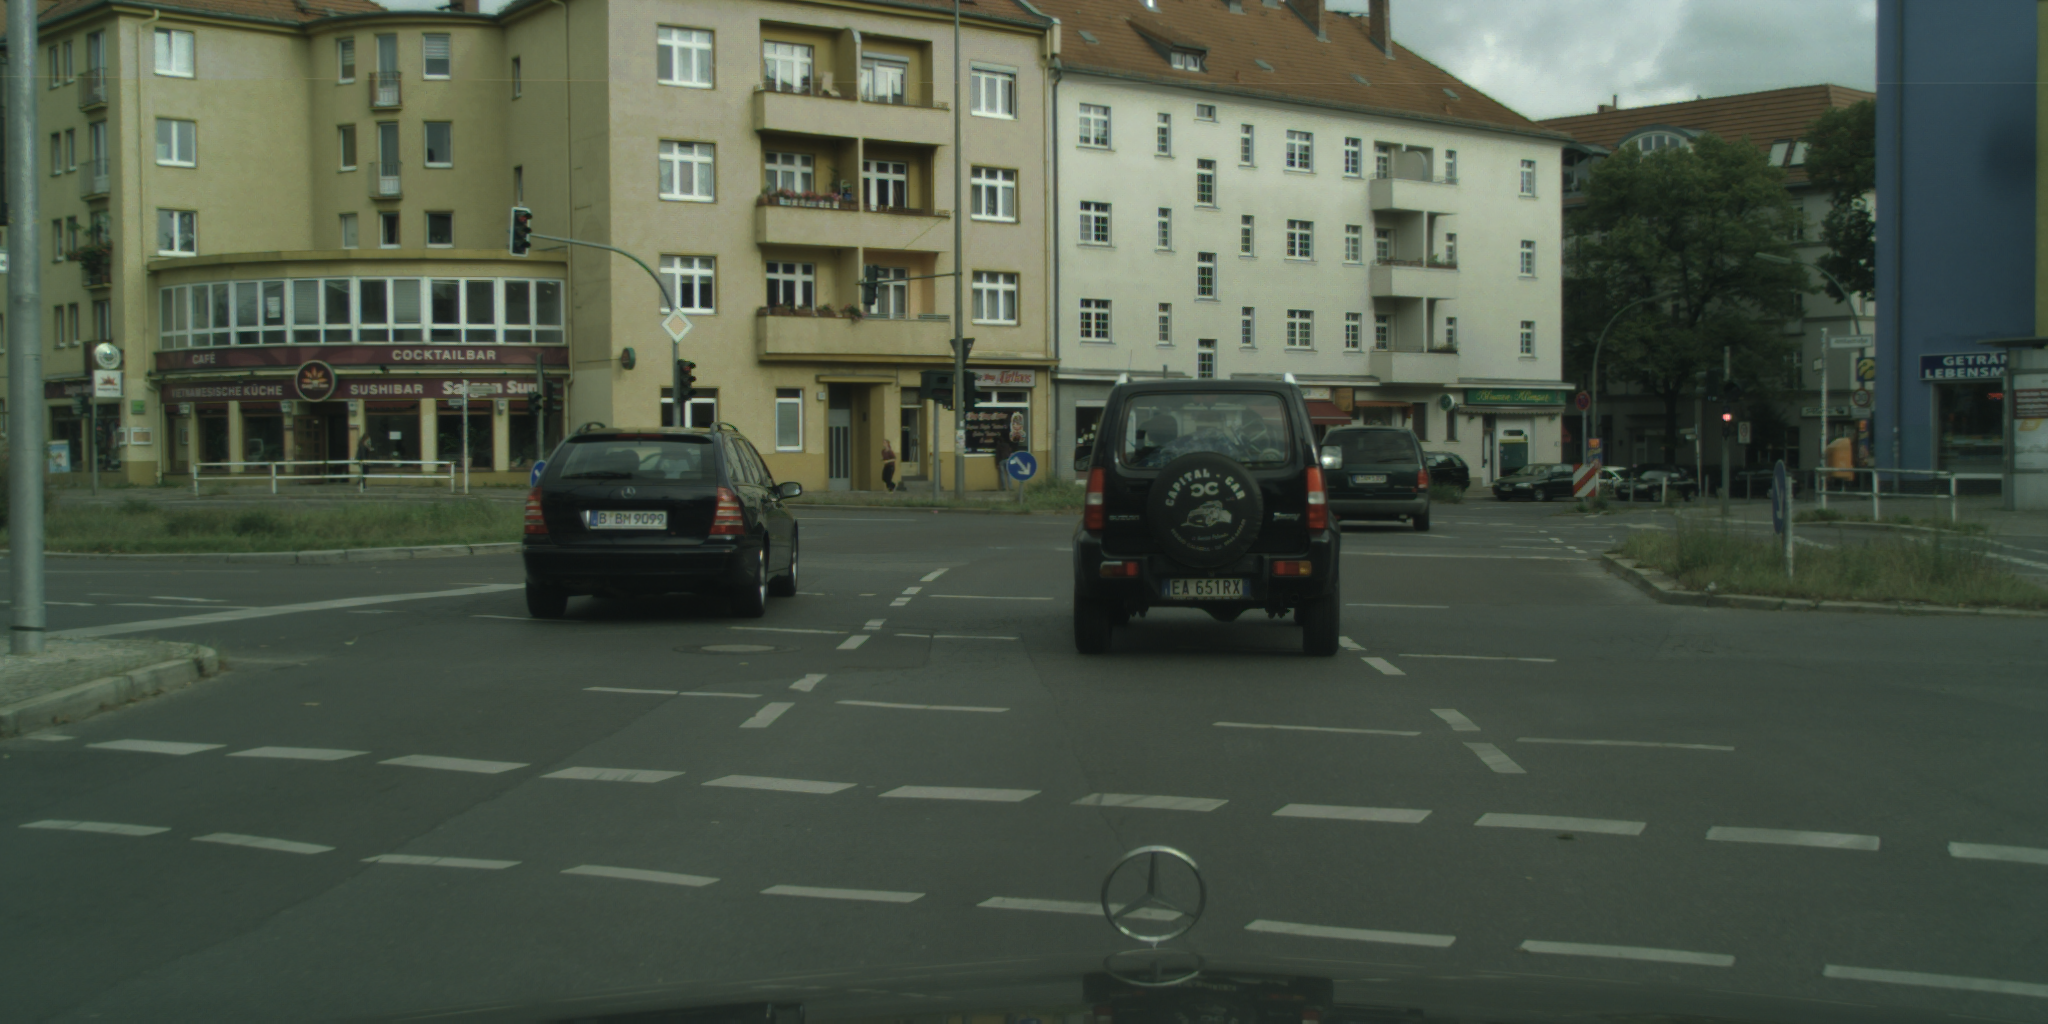

In [6]:
# display input image
Image.fromarray(im)

### Prepare ONNX model and set context

In [7]:
# path to ONNX model
model_path = 'ResNet101_DUC_HDC.onnx'

# Determine and set context
if len(mx.test_utils.list_gpus())==0:
    ctx = mx.cpu()
else:
    ctx = mx.gpu(0)

In [8]:
# Load ONNX model
mod = get_model(ctx, model_path)

### Get preprocessed image

In [9]:
pre = preprocess(im)

### Get predictions

In [10]:
conf,result_img,blended_img,raw = predict(pre)

### Display segmented output
Each pixel is colored with a different color according to the class into which they are classified. Refer to cityscape_labels.py for category names and their corresponding colors.

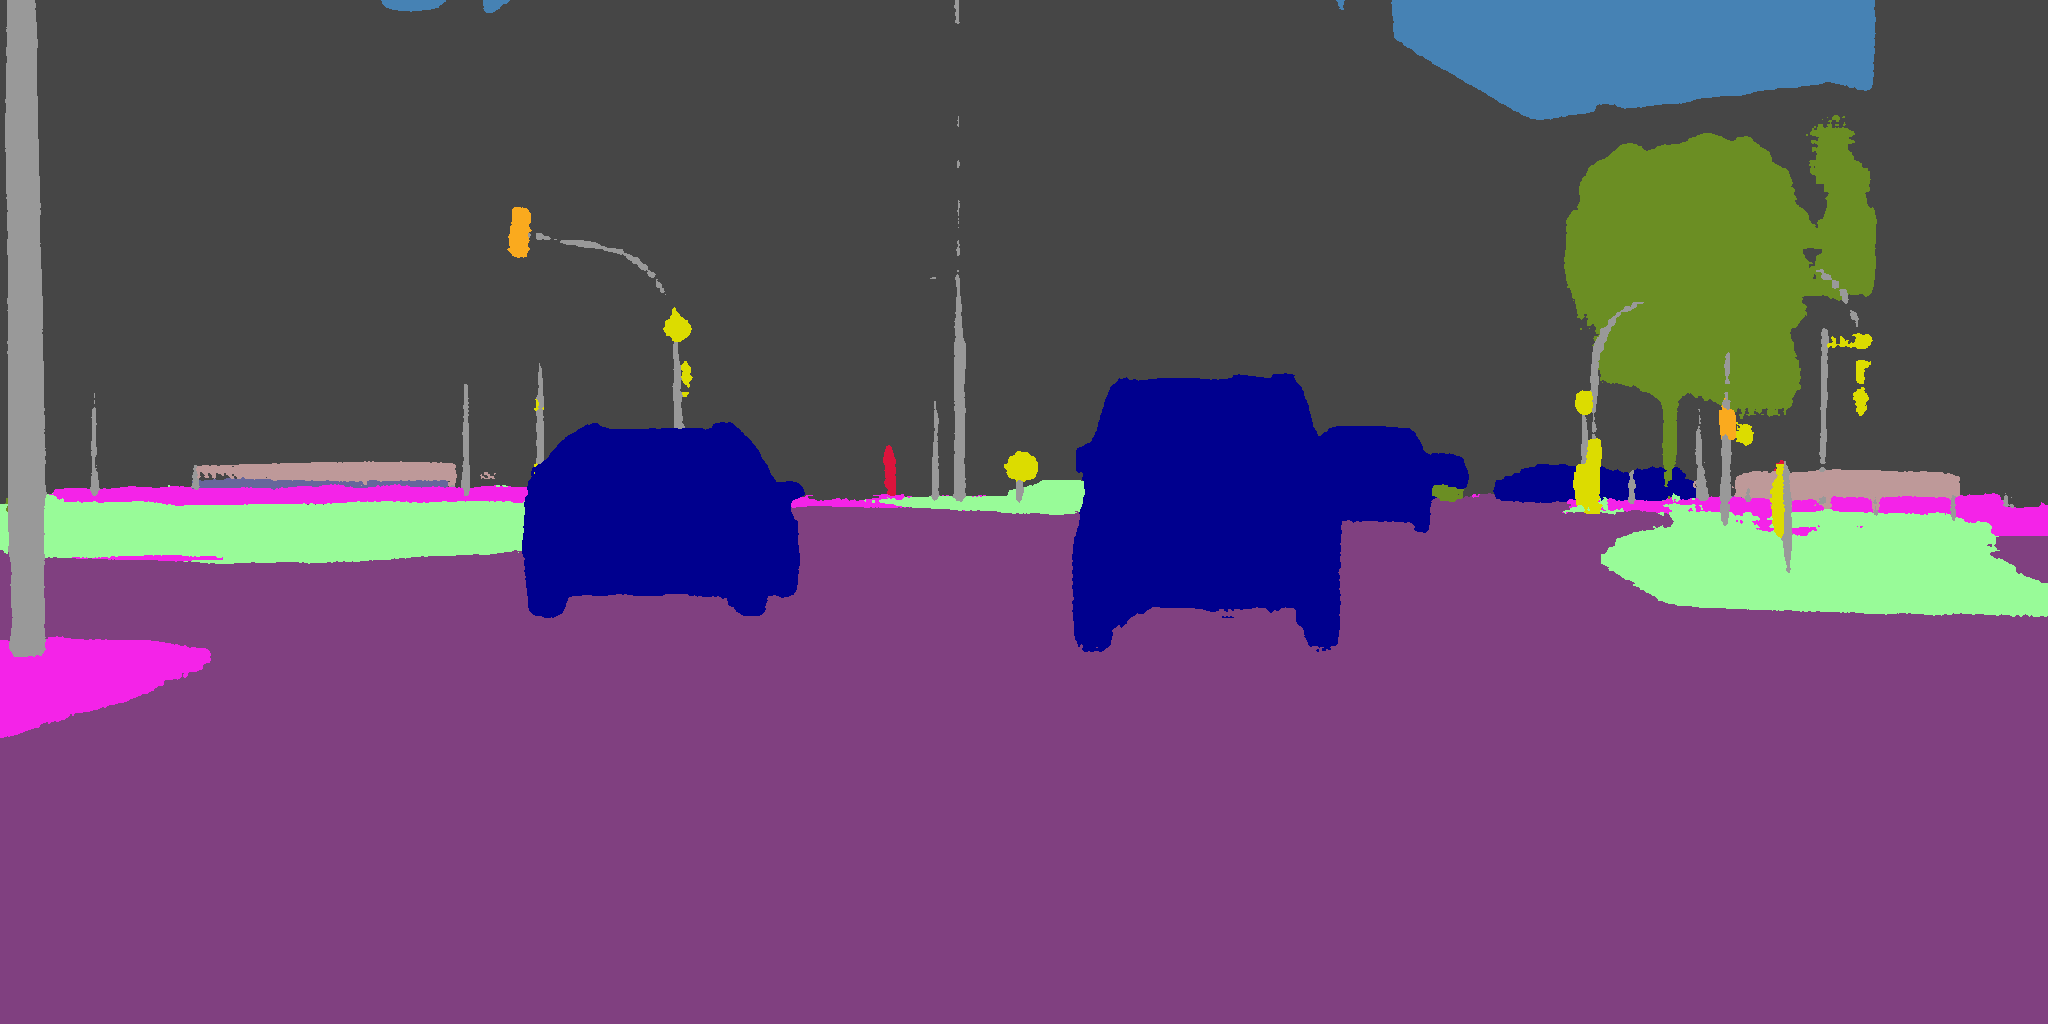

In [11]:
result_img

### Display blended output
The segmentation map is overlayed on top of the input image to have a more precise visualization

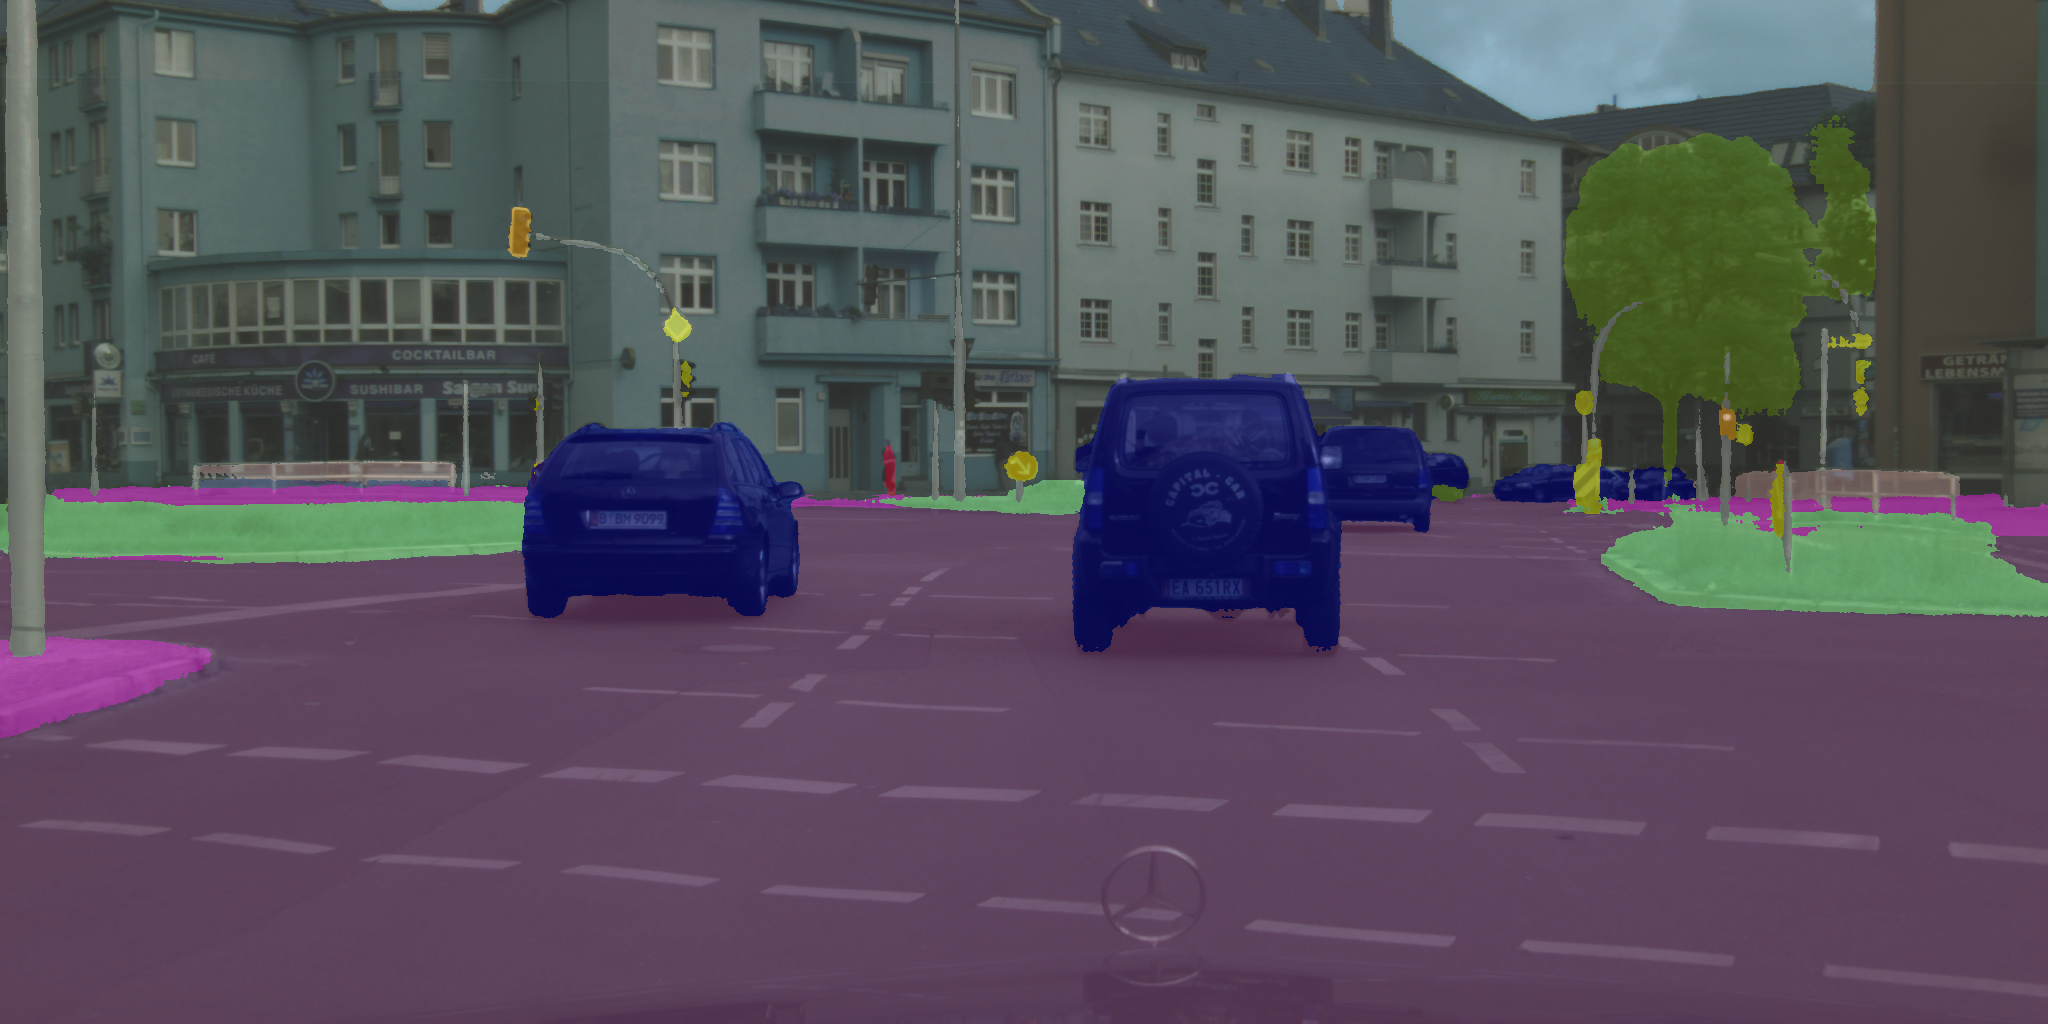

In [12]:
blended_img

### Print confidence score
Confidence score is the maximum value of softmax output averaged over all pixels. The values lie in [0,1] with a higher value indicating that the model is more confident in classification of the pixels, which leads to a better output.

In [13]:
print('Confidence = %f' %(conf))

Confidence = 0.975776
